## Initialization

In [1]:
import matplotlib.pyplot as plt
from mog_model import *
from utils.distributions import *
import pickle
%autoreload 2

In [31]:
x_dim = 2
num_distributions = 6
sigma = 0.01

#MEANS = np.zeros((X_DIM, X_DIM), dtype=np.float32)
#CENTERS = np.sqrt(2)  # center of Gaussian
#for i in range(NUM_DISTRIBUTIONS):
#    MEANS[i::NUM_DISTRIBUTIONS, i] = CENTERS

covs, distribution = gen_ring(r=1., var=sigma, nb_mixtures=num_distributions)
mus = np.array(distribution.mus)
diffs = mus[1:] - mus[:-1, :]
distances = [np.sqrt(np.dot(d, d.T)) for d in diffs]

<IPython.core.display.Javascript object>


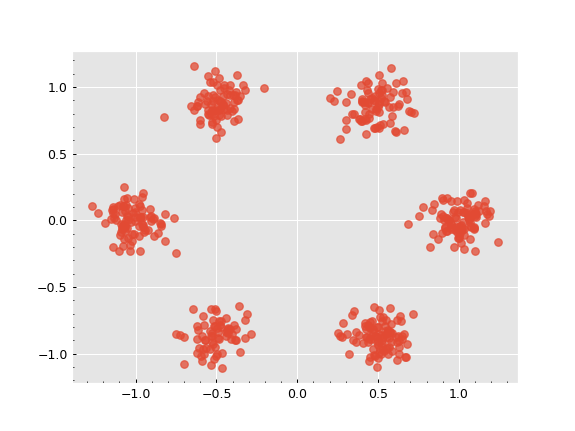

In [32]:
%matplotlib notebook
samples = distribution.get_samples(500)
fig, ax = plt.subplots()
ax.plot(samples[:,0], samples[:,1], marker='o', ls='', alpha=0.75)
plt.show()
#plt.savefig('../log_mog_tf/run_326/figures/target_distribution.pdf', dpi=400, bbox_inches='tight')

In [30]:
x_dim = 2
sigma = 0.02
centers = 1
means = np.zeros((x_dim, x_dim), dtype=np.float32)
for i in range(x_dim):
    means[i::x_dim, i] = centers
cov_mtx = sigma * np.eye(x_dim).astype(np.float32)
covs = np.array([cov_mtx] * x_dim).astype(np.float32)
dist_arr = distribution_arr(x_dim, 2)
gmm_dist = GMM(means, covs, dist_arr)

gmm_mus = np.array(gmm_dist.mus)
gmm_diffs = gmm_mus[1:] - gmm_mus[:-1, :]
gmm_distances = [np.sqrt(np.dot(d, d.T)) for d in gmm_diffs]
gmm_distances

[1.4142135]

<IPython.core.display.Javascript object>


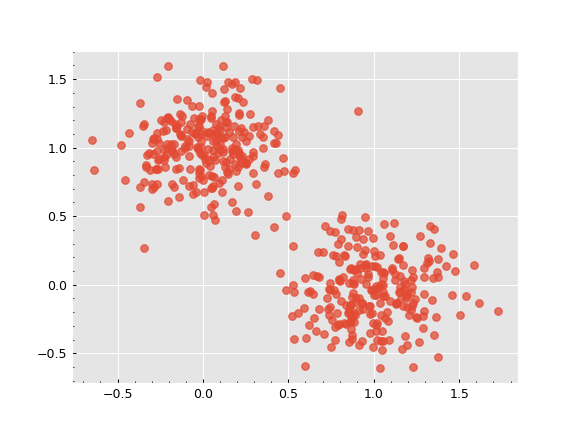

In [29]:
gmm_samples = gmm_dist.get_samples(500)
fig, ax = plt.subplots()
ax.plot(gmm_samples[:,0], gmm_samples[:,1], marker='o', ls='', alpha=0.75)
plt.show()

In [3]:
x_dim = 2
num_distributions = 6
sigma = 0.005

#MEANS = np.zeros((X_DIM, X_DIM), dtype=np.float32)
#CENTERS = np.sqrt(2)  # center of Gaussian
#for i in range(NUM_DISTRIBUTIONS):
#    MEANS[i::NUM_DISTRIBUTIONS, i] = CENTERS

covs, distribution = gen_ring(r=1.0, var=sigma, nb_mixtures=num_distributions)
means = distribution.mus

params = {                          # default parameter values
    'x_dim': x_dim,
    'num_distributions': num_distributions,
    'means': means,
    'sigma': 0.05,
    'small_pi': 2E-16,
    'scale': 0.1,
    'num_samples': 200,
    'lr_init': 1e-3,
    'lr_decay_steps': 1000,
    'lr_decay_rate': 0.96, 'eps': 0.5,
    'temp_init': 20,
    'annealing_steps': 200,
    'annealing_rate': 0.98,
    #'train_trajectory_length': 15,
    #'test_trajectory_length': 2000,
    'num_training_steps': 30000,
    'tunneling_rate_steps': 1000,
    'save_steps': 1000,
    'logging_steps': 100
}

## Build / Train model

In [4]:
samples = distribution.get_samples(100)

In [4]:
samples.shape

(100, 2)

In [8]:
tf.reset_default_graph()

In [6]:
#%pdb
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
kwargs = {'radius': 1.0, 'sigma': 0.01, 'num_distributions': 6}
model = GaussianMixtureModel(params, 
                             config=config,
                             log_dir=None,
                             covs=covs,
                             distribution=distribution,
                             **kwargs)
                             #log_dir='../log_mog_tf/run_22_diag_271/')
                             #log_dir='../log_mog_tf/run64/')

Creating directory for new run: ../log_mog_tf/run_310/
Initial parameters written to ../log_mog_tf/run_310/run_info/_init_params.pkl.
################################################################################
Model parameters:
x_dim: 2

num_distributions: 6

eps: 0.5

scale: 0.1

num_samples: 200

sigma: 0.05

small_pi: 2e-16

lr_init: 0.001

temp_init: 20

annealing_steps: 200

annealing_factor: 0.98

num_training_steps: 30000

tunneling_rate_steps: 1000

lr_decay_steps: 1000

lr_decay_rate: 0.96

logging_steps: 100

save_steps: 1000

arrangement: axes

radius: 1.0

annealing_rate: 0.98

temp: 20

step_init: 0

_annealing_steps_init: 200

_tunneling_rate_steps_init: 1000

log_dir: ../log_mog_tf/run_310/

info_dir: ../log_mog_tf/run_310/run_info/

figs_dir: ../log_mog_tf/run_310/figures/

trajectory_length: 3.0

################################################################################




## Train model

In [7]:
model.train(20000)

---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
    0/20000    19.6      222.6       0.4836        0.001       0.4995          2      
  100/20000    19.6      4.614       0.5294        0.001       0.4939          2      
  200/20000   19.21     -19.36       0.6293        0.001       0.4838          2      
  300/20000   19.21     -24.46       0.6025        0.001       0.4804          2      
  400/20000   18.82     -28.19       0.6454        0.001       0.4815          2      
  500/20000   18.82     -40.25       0.5852        0.001       0.4816          2      

KeyboardInterrupt detected! 
Saving current state and exiting.



## Testing dynamics

In [20]:
step = 1
t = model.dynamics._format_time(step, tile=tf.shape(model.x)[0])
grad1 = model.dynamics.grad_energy(model.x, aux=None)
S1 = model.dynamics.VNet([model.x, grad1, t, None])

In [21]:
sv1 = 0.5 * model.dynamics.eps * S1[0]
tv1 = S1[1]
fv1 = model.dynamics.eps * S1[2]

In [24]:
from utils.dynamics import safe_exp
prod_sv1 = tf.multiply(model.z, safe_exp(sv1, name='sv1F'))
prod_fv1 = tf.multiply(safe_exp(fv1, name='fv1F'), grad1)
v_h = prod_sv1 + 0.5 * model.dynamics.eps * (-prod_fv1 + tv1)

In [28]:
model.sess.run(v_h, feed_dict={model.x: samples, model.dynamics.temperature: 1.}).shape

(100, 2)

In [17]:
model.sess.run(tf.global_variables_initializer())

In [18]:
model.sess.run(vnet, feed_dict={model.x: samples, model.dynamics.temperature: 1.})

[array([[-0.16493094,  0.10004426],
        [-0.13154358,  0.34069416],
        [-0.24086183, -0.24672726],
        [-0.1714805 ,  0.02355536],
        [-0.2740885 , -0.08008911],
        [-0.1496959 , -0.14191352],
        [-0.1682138 ,  0.46480742],
        [-0.1827162 , -0.25866538],
        [-0.15540472,  0.17021209],
        [-0.30985868,  0.6359689 ],
        [-0.15949534,  0.2735524 ],
        [-0.1476932 , -0.22506686],
        [-0.33706862, -0.63749194],
        [-0.0975752 ,  0.2984231 ],
        [-0.12189759,  0.3065236 ],
        [-0.35338894,  0.7086532 ],
        [-0.28831613,  0.5056133 ],
        [-0.35117045, -0.33869362],
        [-0.07468105, -0.00434444],
        [-0.18142277,  0.36199695],
        [-0.19999573,  0.5598908 ],
        [-0.2114325 ,  0.5344103 ],
        [-0.19055694,  0.29619583],
        [-0.17987587, -0.18405293],
        [-0.37052068, -0.41144934],
        [-0.11247279,  0.29201078],
        [-0.36042774,  0.5787242 ],
        [-0.22568433,  0.581

In [22]:
model._restore_model()

Restoring previous model from: ../log_mog_tf/run_22_diag_271/model.ckpt-39999
INFO:tensorflow:Restoring parameters from ../log_mog_tf/run_22_diag_271/model.ckpt-39999
Model restored.



In [12]:
model.train(10)

Restoring previous model from: ../log_mog_tf/run_22_diag_271/model.ckpt-39999
INFO:tensorflow:Restoring parameters from ../log_mog_tf/run_22_diag_271/model.ckpt-39999
Model restored.

---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
40000/40010   1.006      1311       1.71e-06     0.0001954     0.5804          3      


In [23]:
trajectories, loss_arr, accept_arr = model.generate_trajectories()

In [26]:
#trajectories[:, 0, :]
trajectories[:20,0, :]

array([[ 1.6270784 , -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887]])

In [38]:
_samples = model.distribution.get_samples(200)
trajectories = []
for step in range(100):
    _samples = model.distribution.get_samples(200)
    trajectories.append(np.copy(_samples))
    feed_dict = {model.x: _samples,
                 model.dynamics.temperature: 1.}
    loss, _samples, px = model.sess.run([
        model.loss,
        model.output[0],
        model.px,
    ], feed_dict=feed_dict)

#  _, loss_, model.samples, px_, lr_, = model.sess.run([
#_, loss_, _samples, px_, lr_, = model.sess.run([
#    model.train_op,
#    model.loss,
#    model.output[0],
#    model.px,
#    model.learning_rate
#], feed_dict=feed_dict)

In [39]:
trajectories = np.array(trajectories)
np.array(trajectories).shape

(100, 200, 2)

In [40]:
trajectories[:20, 0, :]

array([[ 0.22690701,  1.0176681 ],
       [ 1.48269341,  0.25152916],
       [ 0.7373572 ,  0.0962187 ],
       [-0.30741802,  1.37695288],
       [-0.05400104,  1.7095782 ],
       [ 0.18060045,  1.61676309],
       [ 1.45003324, -0.02905049],
       [ 1.44096197, -0.04440846],
       [ 1.19382557,  0.46499048],
       [-0.16094446,  1.17674708],
       [ 0.93810046,  0.04642486],
       [ 0.16703731,  1.32915737],
       [ 1.47148989, -0.09602996],
       [ 0.07907255,  1.59149825],
       [-0.0442573 ,  1.23372342],
       [-0.08131032,  1.22208512],
       [ 1.93999446,  0.01150151],
       [-0.16744005,  1.46965841],
       [ 1.47258882, -0.05190585],
       [-0.21334952,  1.34552779]])

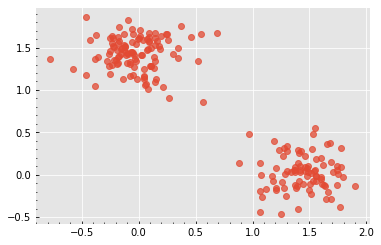

In [57]:
#for i in range(10):
fig, ax = plt.subplots()
ax.plot(_samples[:,0], _samples[:,1], ls='', marker='o', alpha=0.75)
#ax.plot(trajectories[:50, 9, 0], trajectories[:50, 9, 1], ls='-', marker='', alpha=0.6)
plt.savefig('../log_mog_tf/run_22_diag_271/figures/distribution.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [46]:
model.global_step.eval(model.sess)

40001

In [61]:
model.arrangement = 'axes'

In [62]:
model._generate_plots(model.global_step.eval(model.sess))

Saving figure to: ../log_mog_tf/run_22_diag_271/figures/tr_ar_dist_steps_lowT.pdf
Saving figure to: ../log_mog_tf/run_22_diag_271/figures/tr_ar_dist_steps_highT.pdf
Saving figure to: ../log_mog_tf/run_22_diag_271/figures/tr_ar_dist_temps_lowT.pdf
Saving figure to: ../log_mog_tf/run_22_diag_271/figures/tr_ar_dist_temps_highT.pdf
Saving figure to: ../log_mog_tf/run_22_diag_271/figures/annealing_schedule.pdf


In [32]:

_samples1 = model.sess.run([
    model.output[0]
], feed_dict={model.x: _samples, model.dynamics.temperature: 1.})
#_samples

In [33]:
_samples

array([[-0.04825972,  1.6681467 ],
       [-1.1017684 ,  1.4772418 ],
       [ 1.9032845 ,  1.8739713 ],
       [ 0.952036  , -1.4666694 ],
       [-1.3941865 ,  2.493881  ],
       [-0.18121843, -1.3036962 ],
       [-1.361677  ,  2.0898554 ],
       [-1.7863096 ,  2.6423538 ],
       [ 2.5584097 , -1.5798473 ],
       [ 2.1330292 , -1.0426351 ],
       [ 0.4785167 ,  1.3442143 ],
       [-0.8349031 ,  1.2927455 ],
       [-1.2139485 ,  0.7711269 ],
       [-1.4965838 ,  1.2853804 ],
       [ 2.4092393 ,  2.7996662 ],
       [ 0.8232765 ,  0.2041724 ],
       [ 1.2944108 , -1.527963  ],
       [-2.1198728 ,  0.2927999 ],
       [ 2.013573  , -0.8611102 ],
       [ 0.12205063,  0.802365  ],
       [ 0.29903266,  2.6345344 ],
       [ 0.80823004, -1.1293293 ],
       [-1.5458711 ,  0.2832795 ],
       [-1.0067353 ,  2.0859966 ],
       [-0.32478535,  0.9064286 ],
       [ 2.2341614 , -0.47455287],
       [-0.14755844, -0.44172037],
       [ 0.9511992 , -0.14620894],
       [-0.30935544,

In [34]:
_samples1

[array([[-0.04825972,  1.6681467 ],
        [-1.1017684 ,  1.4772418 ],
        [ 1.9032845 ,  1.8739713 ],
        [ 0.952036  , -1.4666694 ],
        [-1.3941865 ,  2.493881  ],
        [-0.18121843, -1.3036962 ],
        [-1.361677  ,  2.0898554 ],
        [-1.7863096 ,  2.6423538 ],
        [ 2.5584097 , -1.5798473 ],
        [ 2.1330292 , -1.0426351 ],
        [ 0.4785167 ,  1.3442143 ],
        [-0.8349031 ,  1.2927455 ],
        [-1.2139485 ,  0.7711269 ],
        [-1.4965838 ,  1.2853804 ],
        [ 2.4092393 ,  2.7996662 ],
        [ 0.8232765 ,  0.2041724 ],
        [ 1.2944108 , -1.527963  ],
        [-2.1198728 ,  0.2927999 ],
        [ 2.013573  , -0.8611102 ],
        [ 0.12205063,  0.802365  ],
        [ 0.29903266,  2.6345344 ],
        [ 0.80823004, -1.1293293 ],
        [-1.5458711 ,  0.2832795 ],
        [-1.0067353 ,  2.0859966 ],
        [-0.32478535,  0.9064286 ],
        [ 2.2341614 , -0.47455287],
        [-0.14755844, -0.44172037],
        [ 0.9511992 , -0.146

In [8]:
model.train(10)

Restoring previous model from: ../log_mog_tf/run_22_diag_271/model.ckpt-39999
INFO:tensorflow:Restoring parameters from ../log_mog_tf/run_22_diag_271/model.ckpt-39999


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [50,2] rhs shape= [20,2]
	 [[Node: save/Assign_86 = Assign[T=DT_FLOAT, _class=["loc:@XNet/linear_t/W"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](XNet/linear_t/W/Adam_1, save/RestoreV2:86)]]

Caused by op 'save/Assign_86', defined at:
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-73ba78d2c186>", line 1, in <module>
    model.train(10)
  File "/Users/saforem2/ANL/l2hmc/l2hmc/mog_model.py", line 881, in train
    saver = tf.train.Saver(max_to_keep=3)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1284, in __init__
    self.build()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1296, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1333, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 781, in _build_internal
    restore_sequentially, reshape)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 422, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 113, in restore
    self.op.get_shape().is_fully_defined())
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 219, in assign
    validate_shape=validate_shape)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [50,2] rhs shape= [20,2]
	 [[Node: save/Assign_86 = Assign[T=DT_FLOAT, _class=["loc:@XNet/linear_t/W"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](XNet/linear_t/W/Adam_1, save/RestoreV2:86)]]


### Less old

In [ ]:
for key in model.tunneling_rates_highT.keys():
    #print(f'Step num: {key[0]}')
    #print(f'Temp: {key[1]}')
    model.steps_arr.append(key[0])
    model.temp_arr.append(key[1])
    #model.temp_arr.append(key[1])

In [ ]:
for idx in range(len(model.steps_arr)):
    model.steps_arr[idx] += 1

In [ ]:
model.steps_arr

In [ ]:
for key, val in model.tunneling_rates.items():
    model.tunneling_rates_avg.append(val[0])
    model.tunneling_rates_err.append(val[1])
for key, val in model.tunneling_rates_highT.items():
    model.tunneling_rates_avg_highT.append(val[0])
    model.tunneling_rates_err_highT.append(val[1])
    
for key, val in model.acceptance_rates.items():
    model.acceptance_rates_avg.append(val[0])
    model.acceptance_rates_err.append(val[1])
for key, val in model.acceptance_rates_highT.items():
    model.acceptance_rates_avg_highT.append(val[0])
    model.acceptance_rates_err_highT.append(val[1])
    
for key, val in model.distances.items():
    model.distances_avg.append(val[0])
    model.distances_err.append(val[1])
for key, val in model.distances_highT.items():
    model.distances_avg_highT.append(val[0])
    model.distances_err_highT.append(val[1])

In [ ]:
model._save_variables()

In [ ]:
model._init_params(params)

In [ ]:
model._load_variables()

In [ ]:
model.steps_arr

In [ ]:
model.tunneling_rates

In [ ]:
import os

In [ ]:
model.__dict__.keys()

In [ ]:
get_vals_as_arr = lambda _dict: np.array(list(_dict.values()))
tr = get_vals_as_arr(model.tunneling_rates)
ar = get_vals_as_arr(model.acceptance_rates)
dr = get_vals_as_arr(model.distances)
#np.array(list(model.tunneling_rates.values()))

In [ ]:
for key in model.attrs_dict.keys():
    in_file = model.info_dir + key + '.npy'
    if os.path.isfile(in_file):
        setattr(model, key, np.load(in_file))
        print(f'Set model.{key} to values read in from: {in_file}')
        #print(model.key == np.load(in_file))

In [ ]:
model.sess.run(tf.global_variables_initializer())

In [ ]:
attrs_dict = model.attrs_dict

In [ ]:
attrs_dict['steps_arr']

In [ ]:
model.train(params['num_training_steps'], plot=True)

## OLD

In [ ]:
#trajectories, loss_arr, px_arr = model.generate_trajectories(num_samples=100, num_steps=100, temperature=1.)

#config = tf.ConfigProto(log_device_placement=True)
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#model.build_graph()

In [ ]:
def calc_avg_distance1(trajectories):
    distances_arr = []
    for trajectory in trajectories:
        distance_arr = []
        for idx in range(1, len(trajectory)):
            diff = trajectory[idx] - trajectory[idx-1]
            dist = np.sqrt(np.dot(diff, diff.T))
            distance_arr.append(dist)
        distances_arr.append(sum(distance_arr))
    return np.mean(distances_arr)

def calc_avg_distance2(trajectories):
    dist = lambda d: np.sqrt(np.dot(d, d.T))
    #distances_arr = np.mean([[dist(d) for d in [t[:-1, :] - t[1:, :] for t in trajectories]]
    #for trajectory in trajectories:
        diff = trajectory[:-1, :] - trajectory[1:, :]
        distance = sum([np.sqrt(np.dot(d, d.T)) for d in diff])
        distances_arr.append(distance)
    return np.mean(distances_arr)

In [ ]:
%timeit avg_dist = avg_distance_traveled(trajectories.transpose([1,0,2]))
#print(avg_dist)

%timeit avg_dist1 = calc_avg_distance1(trajectories.transpose([1,0,2]))
#print(avg_dist1)

%timeit avg_dist2 = calc_avg_distance2(trajectories.transpose([1,0,2]))
#print(avg_dist2)

distances = np.array([np.sqrt(np.dot(disp, disp.T)) for disp in displacements])

In [ ]:
model.train(params['num_training_steps'], config=config, plot=True)

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
model.build_graph()
model.train(params['num_training_steps'], config=config, plot=False)